In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
============================
Linear OT mapping estimation
============================
"""

# Author: Remi Flamary <remi.flamary@unice.fr>
#
# License: MIT License

# sphinx_gallery_thumbnail_number = 2
import os
from pathlib import Path

import numpy as np
from matplotlib import pyplot as plt
import ot

import condo

(array([[ 0.91840048,  0.99303305],
       [-0.32917877,  1.54590112]]), array([3.67376556, 1.88796175]))


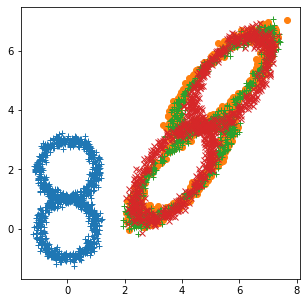

In [2]:
##############################################################################
# Generate data
# -------------

n = 1000
d = 2
sigma = .1

rng = np.random.RandomState(42)

# source samples
angles = rng.rand(n, 1) * 2 * np.pi
xs = np.concatenate((np.sin(angles), np.cos(angles)),
                    axis=1) + sigma * rng.randn(n, 2)
xs[:n // 2, 1] += 2


# target samples
anglet = rng.rand(n, 1) * 2 * np.pi
xt = np.concatenate((np.sin(anglet), np.cos(anglet)),
                    axis=1) + sigma * rng.randn(n, 2)
xt[:n // 2, 1] += 2


A = np.array([[1.5, .7], [.7, 1.5]])
b = np.array([[4, 2]])
xt = xt.dot(A) + b

##############################################################################
# Plot data
# ---------

plt.figure(1, (5, 5))
plt.plot(xs[:, 0], xs[:, 1], '+')
plt.plot(xt[:, 0], xt[:, 1], 'o')


##############################################################################
# Estimate linear mapping and transport
# -------------------------------------

Ae, be = ot.da.OT_mapping_linear(xs, xt)

xst = xs.dot(Ae) + be

cder = condo.ConDoAdapter(
    sampling="proportional",
    joint=True,
    model_type="linear",
    kld_direction="reverse",
    debug=False,
    verbose=0
)
cder.fit(xs, xt, np.ones((n,1))+np.random.normal(0, 1e-3, size=(n,1)), np.ones((n,1))+np.random.normal(0, 1e-3, size=(n,1)))
print((cder.M_, cder.b_))
xs_adapted = cder.transform(xs)    

##############################################################################
# Plot transported samples
# ------------------------

plt.figure(1, (5, 5))
plt.clf()
plt.plot(xs[:, 0], xs[:, 1], '+')
plt.plot(xt[:, 0], xt[:, 1], 'o')
plt.plot(xst[:, 0], xst[:, 1], '+')
plt.plot(xs_adapted[:, 0], xs_adapted[:, 1], 'x')

plt.show()

In [3]:
if False:
    ##############################################################################
    # Load image data
    # ---------------


    def im2mat(img):
        """Converts and image to matrix (one pixel per line)"""
        return img.reshape((img.shape[0] * img.shape[1], img.shape[2]))


    def mat2im(X, shape):
        """Converts back a matrix to an image"""
        return X.reshape(shape)


    def minmax(img):
        return np.clip(img, 0, 1)


    # Loading images
    this_file = os.path.realpath('__file__')
    data_path = os.path.join(Path(this_file).parent, 'data')

    I1 = plt.imread(os.path.join(data_path, 'ocean_day.jpg')).astype(np.float64) / 256
    I2 = plt.imread(os.path.join(data_path, 'ocean_sunset.jpg')).astype(np.float64) / 256


    X1 = im2mat(I1)
    X2 = im2mat(I2)

    ##############################################################################
    # Estimate mapping and adapt
    # ----------------------------

    mapping = ot.da.LinearTransport()

    mapping.fit(Xs=X1, Xt=X2)


    xst = mapping.transform(Xs=X1)
    xts = mapping.inverse_transform(Xt=X2)

    I1t = minmax(mat2im(xst, I1.shape))
    I2t = minmax(mat2im(xts, I2.shape))

    # %%


    ##############################################################################
    # Plot transformed images
    # -----------------------

    plt.figure(2, figsize=(10, 7))

    plt.subplot(2, 2, 1)
    plt.imshow(I1)
    plt.axis('off')
    plt.title('Im. 1')

    plt.subplot(2, 2, 2)
    plt.imshow(I2)
    plt.axis('off')
    plt.title('Im. 2')

    plt.subplot(2, 2, 3)
    plt.imshow(I1t)
    plt.axis('off')
    plt.title('Mapping Im. 1')

    plt.subplot(2, 2, 4)
    plt.imshow(I2t)
    plt.axis('off')
    plt.title('Inverse mapping Im. 2');